In [1]:
from pathlib import Path
import os
import gc
import time
from datetime import datetime

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

# torch and CV tools
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import cv2
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from PIL import Image
from IPython.display import display

In [10]:
MODEL_PATH = 'model/ssdlite.pth'
# path setup
LABEL_PATH = os.path.abspath("data/feed_localization_label_v4.csv")
DATASET_PATH = '/srv/data/feed-ingestion/dataset/2021-05-19/split-jpg-ds/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Load the model

In [3]:
# ssdlite
model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(
    pretrained=False, 
    pretrained_backbone=True,
    nms_thresh=0.25,
    iou_thresh=0.6,
    positive_fraction=0.5,
    num_classes=4)

# check layers' name
for name, layer in model.named_children():
    print(name)

# check requires_grad
for name, param in model.named_parameters():
    if param.requires_grad == False:
        print(name)

backbone
anchor_generator
head
transform


In [23]:
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()
model.to(device)

SSD(
  (backbone): SSDLiteFeatureExtractorMobileNet(
    (features): Sequential(
      (0): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (2): Hardswish()
        )
        (1): InvertedResidual(
          (block): Sequential(
            (0): ConvBNActivation(
              (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (1): ConvBNActivation(
              (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (2): Identity()
            )
          )
        )
 

In [13]:
# load label
class2index = {
    'background': 0,
    'in': 1,
    'out': 2,
    'no_feed': 3
}
index2class = {pair[1]:pair[0] for pair in class2index.items()}
label_df = pd.read_csv(LABEL_PATH)
label_df['bb2'] = label_df['bb2'] + label_df['bb0']
label_df['bb3'] = label_df['bb3'] + label_df['bb1']

# Generating Bounding Box

In [208]:
# util functions
def cv2_imread(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White

def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=1):
    """
    Visualizes a single bounding box on the image
    The visualization function is based on https://github.com/facebookresearch/Detectron/blob/master/detectron/utils/vis.py
    """
    x_min, y_min, x_max, y_max = bbox
    x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)
    #x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img

def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

def show_prediction(img):
    '''
    img: tensor of size (3, H, W)
    '''
    with torch.no_grad():
        model.eval()
        feed_img = [img.squeeze().to(device)]
        predictions = model(feed_img)
    box = predictions[0]['boxes'].tolist()[0]
    score = predictions[0]['scores'].squeeze().tolist()
    score = score if type(score)==float else score[0]
    label = predictions[0]['labels'].squeeze().tolist()
    label = label if type(label)==int else label[0]
    visualize(img.squeeze().permute(1,2,0).numpy(),
          [box], [label], index2class)
    return predictions
    

In [15]:
no_augmentation_func = A.Compose([
                        A.Normalize(mean=(0, 0, 0),
                                     std=(1, 1, 1),
                                     max_pixel_value=255.0,
                                     p=1.0),
                       ToTensorV2()])
class VideoFeedDataset(Dataset):
    def __init__(self, label_file, dataset_folder, split, transform=True, return_filename=False):
        '''
        label_file: str
            path to label csv
        dataset_folder: str
            path to dataset folder
        split: str
            one of the following 'test' or 'train' or 'val'
        '''
        images_path = os.path.join(str(dataset_folder), split)
        self.images = list(Path(images_path).glob('*/*/*'))
        self.transform = transform
        self.return_filename = return_filename
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # setup
        image_path = self.images[idx] # PATH
        filename = image_path.parts[-2] # filename from PATH
        box = (label_df[
            label_df.filename == filename
            ][['bb0', 'bb1', 'bb2', 'bb3']].values/5
        )
        label = (
            label_df[label_df.filename == filename]['label'].values[0]
        )
        image = cv2_imread(str(image_path))
        
        # return class=3 for no-feed
        if label == 0:
            transformed = no_augmentation_func(image=image)
            # return  image, box, label
            return transformed['image'],\
                   torch.tensor(np.array([[0,0,384,216]])).float(),\
                   torch.tensor(3).long().unsqueeze(dim=0)
            
        # image transformation
        if self.transform: transform_func = augmentation_func
        else: transform_func = no_augmentation_func
        class_labels = [label]
        transformed = transform_func(image=image, bboxes=box, class_labels=class_labels)
        # return  image, box, label
        try:
            return transformed['image'],\
                   torch.tensor(transformed['bboxes'][0]).float().unsqueeze(dim=0),\
                   torch.tensor(transformed['class_labels'][0]).long().unsqueeze(dim=0)
        except Exception as error:
            print(error)
            raise ValueError(f'error at file {filename}')


In [330]:
valid_ds = VideoFeedDataset(LABEL_PATH, DATASET_PATH, 'val', False)
iterator = iter(valid_ds)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


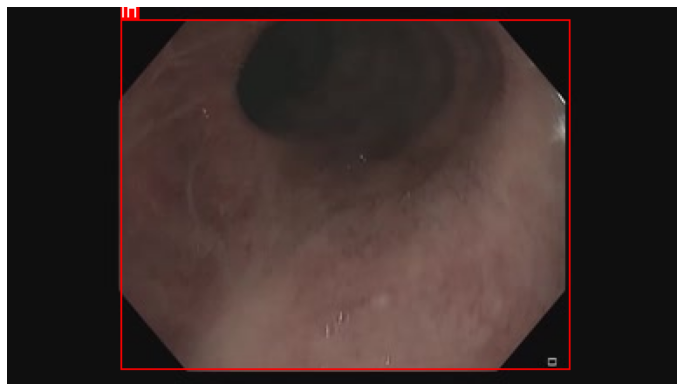

In [355]:
# get img and display
img, _, __ = next(iterator)
predictions = show_prediction(img)

In [328]:
predictions

[{'boxes': tensor([[ 64.3081,   5.2233, 320.8940, 208.5876],
          [ 66.4544,   7.4835, 322.5934, 207.4183]], device='cuda:0'),
  'scores': tensor([0.9414, 0.1849], device='cuda:0'),
  'labels': tensor([1, 2], device='cuda:0')}]